In [2]:
import csv
import pandas as pd
import itertools
import math
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy
import string
import re
import nltk
import random
from google.colab import files
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import classification_report, plot_confusion_matrix

In [3]:
# Import and normalize the json file 
df_2020pb = pd.read_json('https://raw.githubusercontent.com/2020PB/police-brutality/data_build/all-locations-v2.json')
df_2020pb = pd.json_normalize(df_2020pb['data'])
df_2020pb = df_2020pb.drop(columns=['edit_at'])

# Clean the urls
def cleanlinks(json):
    links_out = []
    for link in json:
        links_out.append(link['url'])
    return links_out


df_2020pb['links'] = df_2020pb['links'].apply(cleanlinks)
df_2020pb['date'] = pd.to_datetime(df_2020pb['date'],format='%Y-%m-%d')

# Create a list of all the tags
all_tags = df_2020pb['tags'].copy()
tags = set()
for taglist in all_tags:
  for tag in taglist:
    if tag not in tags:
      tags.add(tag)

df_2020pb.rename(columns={'name':'title'}, inplace=True)

df_2020pb.head()

,links,state,city,description,tags,geolocation,title,date,date_text,id
0,[https://www.wyff4.com/article/tear-gas-rubber...,North Carolina,Asheville,According to eyewitness accounts and news repo...,"[child, less-lethal, protester, rubber-bullet,...","35.5909699, -82.5737781",Police fire tear gas and rubber bullets at pro...,2020-05-31,May 31st,nc-asheville-2
1,[https://twitter.com/AngelaMWilhelm/status/126...,North Carolina,Asheville,"Police destroy supplies, including food and wa...","[medic, property-destruction]","35.5948849, -82.5523578",Police surround approved medical station and d...,2020-06-02,June 2nd,nc-asheville-1
2,[https://twitter.com/greg_doucette/status/1270...,North Carolina,Asheville,A man was shot in the head at close range with...,"[less-lethal, pepper-ball, protester, shoot]","35.5903468, -82.574270",Man shot in head with pepper ball,NaT,Unknown Date,nc-asheville-3
3,"[https://ashevilleblade.com/?p=3904, https://t...",North Carolina,Asheville,A journalist working for The Asheville Blade w...,"[arrest, inhumane-treatment, journalist, zip-tie]","35.5950462, -82.5564847",Reporter for The Blade arrested at protest,2020-08-09,August 9th,nc-asheville-4
4,"[https://www.instagram.com/tv/CA9UOKAj7MC/, ht...",North Carolina,Charlotte,Law enforcement close on protesters from both ...,"[less-lethal, pepper-ball, protester, stun-gre...","35.2254977, -80.8452494",Law enforcement close on protesters from both ...,2020-06-02,June 2nd,nc-charlotte-1


In [4]:
df_titles = df_2020pb[['id', 'title']]

df_titles.head()
#DF from 2020pb

,id,title
0,nc-asheville-2,Police fire tear gas and rubber bullets at pro...
1,nc-asheville-1,Police surround approved medical station and d...
2,nc-asheville-3,Man shot in head with pepper ball
3,nc-asheville-4,Reporter for The Blade arrested at protest
4,nc-charlotte-1,Law enforcement close on protesters from both ...


In [5]:
# Import not_brutality training csv

train_not_brutality = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/Labs27-C-HRF-DS/main/notebooks/news.csv')

# Import is_brutality training csv


train_brutality = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/Labs27-C-HRF-DS/main/notebooks/police_use_force.csv')

In [6]:
# Assign 0 to the police_brutality score in the not_brutality training csv and drop extraneous columns

train_not_brutality['police_brutality'] == 0

train_not_brutality = train_not_brutality.drop(['id', 'score','subreddit', 'url','num_comments','text','created'], axis=1)

train_not_brutality.head()

,title,police_brutality
0,Blizzard Employees Staged a Walkout After the ...,0
1,Kobe Bryant killed in helicopter crash in Cali...,0
2,Scientist Stephen Hawking has died aged 76,0
3,Jeffrey Epstein's autopsy more consistent with...,0
4,F.C.C. Announces Plan to Repeal Net Neutrality,0


In [7]:
# Ensure that the police brutality column consists of all 1s and rename name column

train_brutality['police_brutality'] == 1

train_brutality.rename(columns={'name':'title'}, inplace=True)

train_brutality.head()

,title,police_brutality
0,Compilation of incidents,1
1,Police shove a protesting woman down a set of ...,1
2,Police throw tear-gas at protesters on a bridge.,1
3,Police assault protesters,1
4,Police shoot non-violent protester in the head,1


In [8]:
# Combine training data

df = pd.concat([train_brutality, train_not_brutality])

df.head()

,title,police_brutality
0,Compilation of incidents,1
1,Police shove a protesting woman down a set of ...,1
2,Police throw tear-gas at protesters on a bridge.,1
3,Police assault protesters,1
4,Police shoot non-violent protester in the head,1


In [9]:
# Create tokenizer functions

nlp = spacy.load("en")


def tokenize(text):
    text = nlp(text)
    tokens = [token.lemma_ for token in text if (token.is_stop != True) and (token.is_punct != True) and (token.text != " ")]
    return tokens

def retoken(text):   
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    tokens = str(tokens)
    
    return tokens

In [10]:
# Apply tokenizer functions to our combined dataframe

df['tokens'] = df['title'].apply(tokenize)

df['tokens'] = df['title'].apply(retoken)

df.head()

,title,police_brutality,tokens
0,Compilation of incidents,1,"['compilation', 'of', 'incidents']"
1,Police shove a protesting woman down a set of ...,1,"['police', 'shove', 'a', 'protesting', 'woman'..."
2,Police throw tear-gas at protesters on a bridge.,1,"['police', 'throw', 'teargas', 'at', 'proteste..."
3,Police assault protesters,1,"['police', 'assault', 'protesters']"
4,Police shoot non-violent protester in the head,1,"['police', 'shoot', 'nonviolent', 'protester',..."


In [11]:
# Create vectorizer and fit and transform the tokens column 

vect = CountVectorizer()
vect.fit(df['tokens'])
dtm = vect.transform(df['tokens'])

In [12]:
# Create datafrane from features

dtm_df = pd.DataFrame(dtm.todense(), columns = vect.get_feature_names())

dtm_df.head()

,10,100,1000,10000,100000,100150,101,104,107,10acre,10bn,10th,10year,10yearold,11,11000,112,117,1191,11943,11th,11yearold,12,1200,120000,127700,12m,12th,12yearold,12yearolds,13,130,1300,13k,13th,14,14000,141,14yearold,15,...,wrongful,wrote,wtop,wuhan,wv,xbox,xi,xl,xxx,yang,yard,yards,yates,year,years,yearslong,yeezy,yelled,yelling,yellow,yells,yellsmerry,yiannopoulos,york,you,youd,young,younger,youporn,your,youre,youtube,zap,zealand,zeroes,zimbabwe,zip,zoo,zoom,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Separate dataframe into train and test datasets


X = df['title']
y = df['police_brutality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1590,)
(398,)
(1590,)
(398,)


In [28]:
X.head()

0                             Compilation of incidents
1    Police shove a protesting woman down a set of ...
2     Police throw tear-gas at protesters on a bridge.
3                            Police assault protesters
4       Police shoot non-violent protester in the head
Name: title, dtype: object

In [29]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: police_brutality, dtype: int64

In [23]:
# Build model pipeline using KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=16, leaf_size=37)),
])
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# Fit model 


param_distributions = {
   'classifier__leaf_size': list(range(1,50)),
   'classifier__n_neighbors': list(range(1,30)),
   'classifier__p': [1,2]}

search = RandomizedSearchCV(
   pipeline, 
   param_distributions=param_distributions, 
   n_iter=10, 
   cv=10, 
   scoring='accuracy', 
   verbose=10, 
   return_train_score=True, 
   n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.8s finished


In [24]:
# Check best parameters for further tuning

print('Best hyperparameters', search.best_params_)
print('Best Score', search.best_score_)

Best hyperparameters {'classifier__p': 2, 'classifier__n_neighbors': 16, 'classifier__leaf_size': 37}
Best Score 0.909433962264151


In [25]:
# Check classification report 

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       209
           1       0.84      0.99      0.91       189

    accuracy                           0.91       398
   macro avg       0.92      0.91      0.91       398
weighted avg       0.92      0.91      0.91       398



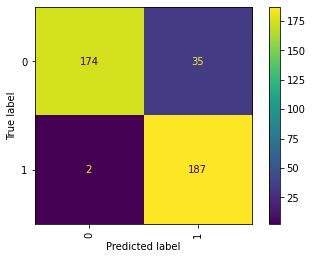

In [26]:
# Plot confusion matrix 

cm = plot_confusion_matrix(pipeline, X_test, y_test, values_format='.0f', xticks_rotation='vertical')
cm;

In [27]:
# Obtain ROC AUC score

from sklearn.metrics import roc_auc_score

y_pred_proba = pipeline.predict_proba(X_test)[:, -1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.9891901470848838
